# <a id='the_top'>Random max-cut using Marcov chain monte carlo (MCMC) method</a>

In this notebook we solve the aforementioned problem using the <a href='https://en.wikipedia.org/wiki/Canonical_ensemble'>canonical ensembele</a> (<a href='https://en.wikipedia.org/wiki/Gibbs_sampling'>Gibbs ensemble</a>), where the the probabilty of a $i^{th}$ configuration is:

$$ P(E_i) \sim e^{-\frac{E}{K_BT}} $$

$K_B$ is known as the Boltzman constant, which we will assume to be one, since this doesn't affect our understanding.

First let's define the problem bellow, then we can discuss how to solve it.

The problem is in a graph the nodes can have $\{-1,1\}$ values. Given a set of undirected connection of weight $\{-1,+1\}$, we want minimize the cost function:

$$ C=\sum_{i,j}J_{i,j}s_is_j $$

This nottebook is divided into the following parts:

* <a href='#build_up'>Building up for MCMC<a/>
* <a href='#mcmc'>Solving the problem using MCMC</a>
* <a href='#ed'>Understanding the full picture using exact diagonalization</a>
* <a href='#temp'>The concept of temperature</a>

In [1]:
# general packages
import numpy as np
import math
import networkx as nx

# for scintific computing
import scipy.sparse as sps
from functools import reduce
from collections import Counter

# visualization
import matplotlib.pyplot as plt

In [2]:
L=7

# total number of bond 
N_all_possible=math.factorial(L)/(math.factorial(2)*(math.factorial(L-2)))
N_bond = int(N_all_possible//2)

s=list(range(L))
np.random.seed(391)

# there are L choose 2 (=66) possible random interactions, among them we are choosing 20. Furthermore
# the interactions are being chosen from a uniform distribution b/w [-1,1)

interactions=list(nx.generators.random_graphs.dense_gnm_random_graph(L,N_bond,seed=23).edges())
strength=np.random.choice([1,-1],size=N_bond,p=[.5,.5])
# strength=np.array([-1.]*N_bond)

J_nn=[[strength[i],interactions[i][0],interactions[i][1]] for i in range(N_bond)]
static=[["zz",J_nn]]

interactions;
static

[['zz',
  [[1, 0, 1],
   [1, 0, 2],
   [1, 0, 3],
   [-1, 1, 3],
   [1, 1, 4],
   [1, 1, 6],
   [1, 2, 5],
   [1, 2, 6],
   [-1, 3, 6],
   [-1, 4, 5]]]]

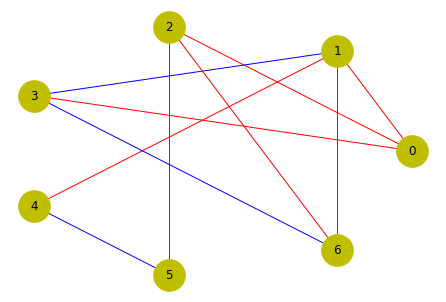

In [3]:
G = nx.Graph()
G.add_nodes_from(s)
for item in J_nn:
    G.add_edge(item[1],item[2],color='r' if (item[0]>0) else 'b',weight=item[0])

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
    
options = {
    'node_color': 'y',
    'node_size': 1000,
}
    
nx.draw(G,with_labels=True,pos=nx.circular_layout(G),edges=edges,edge_color=colors,width=weights,**options)

## <a id='build_up'>Markov Chain monte-carlo</a>

Given the above problem, we will explore the energy landsccape using markov chain monte carlo technique and find out the low energy configuration of the nodes.

Inerestingly since the problem has $Z_2$ symmetry, i.e. for a ground state there will be another state with all the states flipped, which is also a ground state. To use that symmetry we divide the problem with $2^{7}=128$ states and analyze only the half of the system. Later in the exact result we will show how the symmetry accounts for the other half.

In [4]:
def calcEnergy(static,array):
    if len(array)==L-1:
        new_array=np.ndarray(shape=(L,))
        new_array[1:L]=array
        new_array[0]=0
        energy=0
        for item in static[0][1]:
            energy=energy+item[0]*(1-2*new_array[item[1]])*(1-2*new_array[item[2]])
    else:
        new_array=np.ndarray(shape=(L,))
        new_array[0:L]=array
        energy=0
        for item in static[0][1]:
            energy=energy+item[0]*(1-2*new_array[item[1]])*(1-2*new_array[item[2]])
    return energy

rL=L-1

def mcMove(state,T):
    new_state=np.random.randint(2**rL)
    e0=calcEnergy(state)
    e1=calcEnergy(new_state)
    eDel=e1-e0
    if eDel<0:
        return new_state
    elif np.random.rand() < np.exp(-eDel*(1./T)):
        return new_state
    else:
        return state

In [5]:
def int_to_binary_arr(x,rL):
    assert(x<=2**rL)
    local_array=np.zeros(shape=(rL,),dtype=np.int)
    index=0
    while x>0:
        local_array[index]=(int(x%2))
        x=x//2
        index=index+1
    return local_array[::-1]

def binary_arr_to_int(array,rL):
    summ=0
    for i,item in enumerate(array):
        summ += (2**(rL-1-i))*(item)
    assert(summ<2**rL)
    return summ

for j in range(2**7):
    assert(binary_arr_to_int(int_to_binary_arr(j,7),7)==j)

In [6]:
def mcMove(static,state_no,T):
        old_arr=int_to_binary_arr(state_no,rL)
        index=np.random.randint(rL)
        new_arr=np.array(old_arr)
        new_arr[index]=1-new_arr[index]
        e0=calcEnergy(static,old_arr)
        e1=calcEnergy(static,new_arr)
        eDel=e1-e0
        new_state=binary_arr_to_int(new_arr,rL)
        #print('state_no=%d, new_state=%d, eDel=%.2f'%(state_no,new_state,eDel))
        if eDel<0:
            #print('flip')
            return new_state
        elif np.random.rand() < np.exp(-eDel*(1./T)):
            #print('flip')
            return new_state
        else:
            #print('no flip')
            return state_no

# <a id='mcmc'>MC sweep</a>

The algorithm is starting with a random configuration, we let the system to evolve it's energy landsacpe for finite temperature. The notion of the temperature will be clear later. Where we will understand the notion of 'high' and 'low' temperature.

The sweeping algorithm is:
* Start with a random state
* Randomly choose a new state and compare the energies of the two states
> (1) If the energy of the new state is low go to that new state <br>
> (2) If the energy of the new state is high, go to that state with a probabilty
* Keep on doing so for a good amount of time.
* Find out which state is the most visited, which is the best candidate for the ground state.

Bellow in the code block we perform 10 MC sweep for a sweep iteration 16.

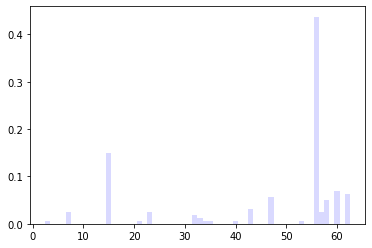

Counter({56: 70, 15: 24, 60: 11, 62: 10, 47: 9, 58: 8, 43: 5, 23: 4, 7: 4, 57: 4, 32: 3, 33: 2, 3: 1, 35: 1, 34: 1, 40: 1, 53: 1, 21: 1})


In [7]:
mcIteration=10
mcSteps=16
temp=.1
total=mcSteps*mcIteration

list_config=[]
np.random.seed(29439)

for j in range(mcIteration):
    init_config=np.random.randint(2**rL)
    for i in range(mcSteps):
        new_config=mcMove(static,init_config,temp)
        init_config=new_config
        list_config.append(init_config)

dictionary=Counter(list_config)
keys=list(dictionary.keys())
values=np.array(list(dictionary.values()),dtype=np.float)/total
#print(keys,values)
plt.bar(keys, values, width=1, color='%s'%('b'),alpha=.15,label='Sampling Temp=%.2f'%(.1))
plt.show()

print(dictionary)

Clearly we see that the state 56 stands out, to undersatnd this configuration, we add the first node, which is held fixed to `0`.

In [8]:
short_string=int_to_binary_arr(56,rL)
new_string=np.ndarray(shape=(L,))

new_string[1:L]=short_string
new_string[0]=0

new_string

array([0., 1., 1., 1., 0., 0., 0.])

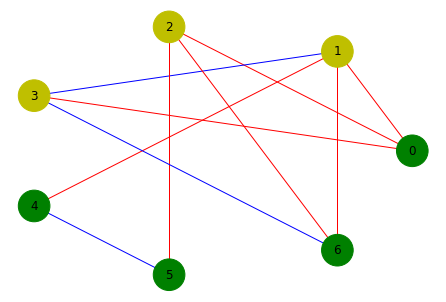

In [9]:
G = nx.Graph()
G.add_nodes_from(s)
for item in J_nn:
    G.add_edge(item[1],item[2],color='r' if (item[0]>0) else 'b',weight=item[0])

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
    
options = {'node_size': 1000,}

n_color=['g' if (node == 0) else 'y' for node in new_string]

nx.draw(G,node_color=n_color,with_labels=True,pos=nx.circular_layout(G),edges=edges,edge_color=colors,width=weights,**options)

Untill now we didn't know about the full problem, we started with a random state in the system and using the MCMC sampling we let the system time evolve for a particular temperature. Now we will try to understand the full energy landscape.

Here we should note that, for a small system like this problem it is easy to look at the full landscape. But in a real life problem where the system is big enough the problem scales as $2^L$, it is impossible to look at the full energy landscape, where the above MCMC method is very usefull.

# <a id='ed'>Now let's understand the full picture using ED</a>

In [10]:
# Loading the Pauli matrices

Id = sps.eye(2)
Sx = sps.csr_matrix(np.array([[0,1.+0.j],[1+0.j,0]]))
Sy = sps.csr_matrix(np.array([[0,-1.j],[1.j,0]]))
Sz = sps.csr_matrix(np.array([[1+0.j,0.],[0,-1+0.j]]))

def ham_general(L,static):
    ham_gen=np.zeros(shape=(2**L,2**L),dtype=np.complex)
    for item in static:
        string=item[0]
        for inside in item[1:len(item)]:
            for j in range(len(inside)):
                op_list=[Id]*L
                for k in range(len(string)):
                    if string[k]=='x':
                        op_list[inside[j][k+1]]=Sx
                    elif string[k]=='y':
                        op_list[inside[j][k+1]]=Sy
                    elif string[k]=='z':
                        op_list[inside[j][k+1]]=Sz
                #print(reduce(sps.kron,op_list).toarray())
                ham_gen += inside[j][0]*reduce(sps.kron,op_list).toarray()
    #            
    return ham_gen

In [11]:
hamiltonian = ham_general(L,static).real

diag_hamiltonian=np.diag(hamiltonian)
sorted_diagonal=np.sort(diag_hamiltonian)

diag_hamiltonian,sorted_diagonal,sorted_diagonal.shape;

In [12]:
eMin=sorted_diagonal[0]
eMax=sorted_diagonal[2**L-1]

eMax,eMin

(6.0, -8.0)

In [13]:
np.where(diag_hamiltonian == eMin)

(array([56, 71]),)

Obviouly we didn't see the 71 since we had analyzed the spectrum untill 63 from 0, using the $Z_2$ symmetry of the problem. Now we will understand the energy ladscape and see the full sampling for a given temperature.

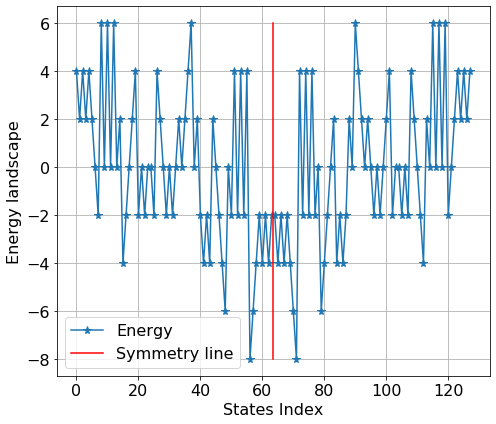

In [14]:
landscape=np.ndarray(shape=(2**L,))

for integer in range(2**L):
    binary_arr=int_to_binary_arr(integer,L)
    landscape[integer]=calcEnergy(static,binary_arr)

plt.figure(figsize=(7,6))
plt.plot(np.arange(2**L),landscape,'*-',markersize=8,label='Energy')
plt.plot([63.5,63.5],[-8,6],'r-',label='Symmetry line')
plt.xlabel('States Index',fontsize=16)
plt.ylabel('Energy landscape',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.tight_layout()
plt.show()

Now, the $Z_2$ symmetry is evident, since this landscape is symmetric about the line $y=63.5$, which is denoted by the red vertical line. Furthermore for a given temperature we can find out the probability distribution using Gibb's sampling and sample that probability distribution.

# <a id='temp'>Notion of temperature</a>

In [15]:
temp=np.linspace(.1,50,20)

probabilities=np.ndarray(shape=(len(temp),2**L))
nProbabilities=np.ndarray(shape=(len(temp),2**L))

for j in range(len(temp)):
    for k in range(2**L):
        state=int_to_binary_arr(k,L)
        probabilities[j,k]=np.exp(-(1./temp[j])*calcEnergy(static,state))
for j in range(len(temp)):
    for k in range(2**L):
        nProbabilities[j,k]=probabilities[j,k]/sum(probabilities[j,:])

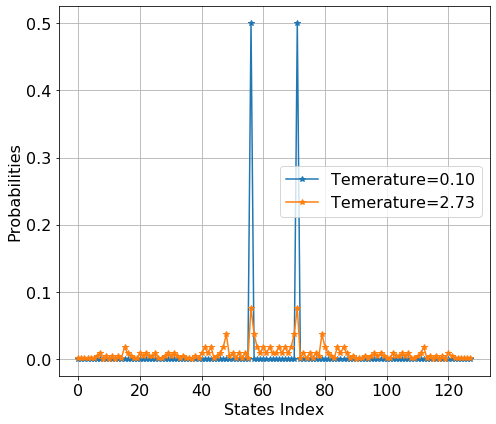

In [16]:
plt.figure(figsize=(7,6))
for j in [0,1]:
    plt.plot(np.arange(2**L),nProbabilities[j,:],'*-',label='Temerature=%.2f'%(temp[j]))
plt.xlabel('States Index',fontsize=16)
plt.ylabel('Probabilities',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.tight_layout()
plt.show()

We see that in a very low temperature the GS of the system stands out with a substantial probability, but bellow we see in high temperature, the probability is more or less uniform.

Notice the bandwidth of the system is : $6-(-8)=14$, this energy or temperature scale is set by the probelm. If $T<<14$, the there is very much chance that the system will be in the ground state, but for $T>>14$, that chance is very less, since the probabilty distribution is uniform.

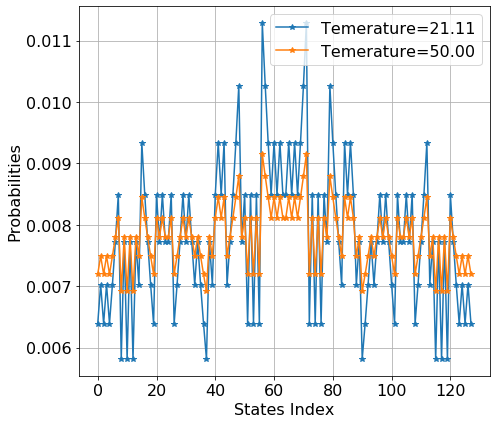

In [17]:
plt.figure(figsize=(7,6))
for j in [8,19]:
    plt.plot(np.arange(2**L),nProbabilities[j,:],'*-',label='Temerature=%.2f'%(temp[j]))
plt.xlabel('States Index',fontsize=16)
plt.ylabel('Probabilities',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.tight_layout()
plt.show()

Moreove rwe can do a random sampling and get back the probabilty:

## High temperature

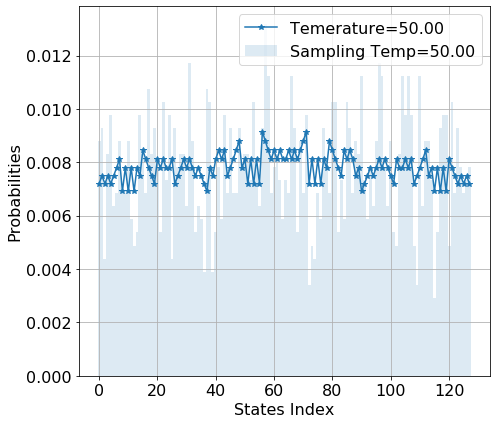

In [18]:
total,j=2048,19
arr=np.random.choice(np.arange(2**(L)), size=total, replace=True, p=nProbabilities[j,:])
dictionary=Counter(arr)
keys=list(dictionary.keys())
values=np.array(list(dictionary.values()),dtype=np.float)/total

plt.figure(figsize=(7,6))
plt.bar(keys, values, width=1,alpha=.15,label='Sampling Temp=%.2f'%(temp[j]))
plt.plot(np.arange(2**L),nProbabilities[j,:],'*-',label='Temerature=%.2f'%(temp[j]))
plt.xlabel('States Index',fontsize=16)
plt.ylabel('Probabilities',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.tight_layout()
plt.show()

## Low temperature

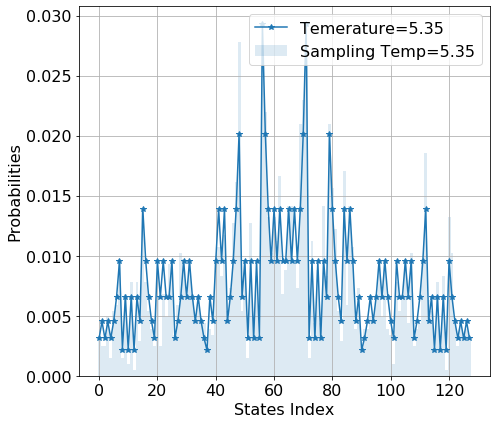

In [19]:
total,j=2048,2
arr=np.random.choice(np.arange(2**(L)), size=total, replace=True, p=nProbabilities[j,:])
dictionary=Counter(arr)
keys=list(dictionary.keys())
values=np.array(list(dictionary.values()),dtype=np.float)/total

plt.figure(figsize=(7,6))
plt.bar(keys, values, width=1,alpha=.15,label='Sampling Temp=%.2f'%(temp[j]))
plt.plot(np.arange(2**L),nProbabilities[j,:],'*-',label='Temerature=%.2f'%(temp[j]))
plt.xlabel('States Index',fontsize=16)
plt.ylabel('Probabilities',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.tight_layout()
plt.show()

We were lucky that, without knowing the bandwidth, we did the sampling and got the almost correct result. Sometimes we need see the result for different temperature, to find out the ground state. Bellow we show a MC sampling of a tempereture $T=50$, which is way above the bandwidth (14). Again we will sample only for the half of the system.

## Sampling in a high temperature

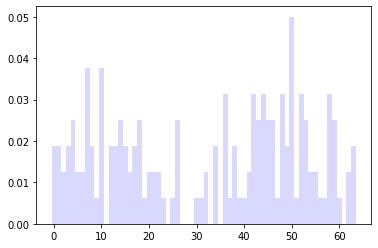

Counter({50: 8, 10: 6, 7: 6, 48: 5, 42: 5, 52: 5, 36: 5, 44: 5, 58: 5, 53: 4, 4: 4, 14: 4, 59: 4, 46: 4, 45: 4, 43: 4, 18: 4, 26: 4, 49: 3, 34: 3, 38: 3, 0: 3, 8: 3, 15: 3, 63: 3, 13: 3, 12: 3, 3: 3, 1: 3, 17: 3, 32: 2, 16: 2, 2: 2, 55: 2, 54: 2, 41: 2, 22: 2, 20: 2, 6: 2, 5: 2, 21: 2, 62: 2, 40: 1, 39: 1, 31: 1, 57: 1, 30: 1, 19: 1, 23: 1, 37: 1, 47: 1, 9: 1, 25: 1, 56: 1, 51: 1, 60: 1})


In [20]:
mcIteration=10
mcSteps=16
total=mcSteps*mcIteration
list_config=[]
temp=50

np.random.seed(23431)

for j in range(mcIteration):
    init_config=np.random.randint(2**rL)
    for i in range(mcSteps):
        new_config=mcMove(static,init_config,temp)
        init_config=new_config
        list_config.append(init_config)

dictionary=Counter(list_config)
keys=list(dictionary.keys())
values=np.array(list(dictionary.values()),dtype=np.float)/total
#print(keys,values)
plt.bar(keys, values, width=1, color='%s'%('b'),alpha=.15,label='Sampling Temp=%.2f'%(.1))
plt.show()

print(dictionary)

Clealry this is not a conclusive result to find out the GS.


Interestingly there exist another method of monte carlo sampling where we start from a very high tempereture and reduce the temperature as we simulatet the system, this method is called <a href='https://en.wikipedia.org/wiki/Simulated_annealing'>simulated annealing</a>, which we will discuss later.
<a href='#the_top'>Go to the top</a>